In [8]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import yaml
import dcargs
import pandas as pd

sys.path.append("..") 

from experiment import ExperimentParameters
import glob
from tqdm import tqdm
from yaml.loader import SafeLoader

import postpro_centrality_certainty as postpro

# path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/"
default_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/hpc_mount/"
experiment_name = "N100_2023-09-15-16-19-36_certainty_search_Naive_centralized_random_fixed_mdeg"
experiment_name = "N100_2023-09-15-18-09-46_certainty_search_Bayes_centralized_random_fixed_mdeg"

# # command for mounting hpc 
#  sshfs m.raoufi.s@gateway.hpc.tu-berlin.de:/home/users/m/m.raoufi.s/colab/collective-decison-making-with-direl/results hpc_mount/


path = default_path + experiment_name 

sys.path.append(path)


In [2]:
df = pd.read_pickle(path + "/processed_results.pickle")

/home/mohsen/.local/lib/python3.8/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<AxesSubplot: xlabel='scalar_param1', ylabel='Netw_mean_eigVal'>

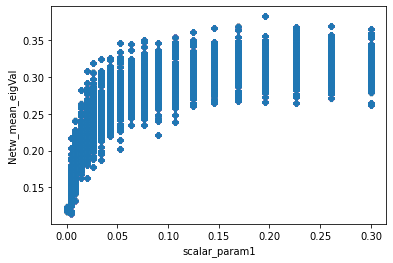

In [7]:
import seaborn as sns   
# sns.scatterplot(df, x="scalar_param1", y="Netw_mean_degree",alpha=0.1,hue="weight_own_belief")
# sns.scatterplot(df, x="scalar_param1", y="Netw_std_degree",alpha=0.01)
sns.scatterplot(df, x="scalar_param1", y="Netw_mean_eigVal",alpha=0.01)
sns.scatterplot(df[df["weight_own_belief"]==1.0], x="scalar_param1", y="Netw_mean_eigVal",alpha=0.01)


Index(['Trueness_Error', 'Precision_Error', 'Accuracy_Error',
       'Collective_Mean', 'Number_of_Agents', 'True_Value', 'Timestep',
       'mean_agent_measurement_noise', 'range_agent_measurement_noise',
       'std_environment_noise', 'scalar_param1', 'weight_own_belief',
       'Netw_num_of_Edges', 'Netw_std_degree', 'Netw_mean_degree',
       'Netw_std_eigVec', 'Netw_mean_eigVec', 'Netw_max_eigVec', 'Netw_std_CC',
       'Netw_mean_CC', 'Netw_max_CC', 'Netw_std_eigVal', 'Netw_mean_eigVal',
       'Netw_max_eigVal', 'Netw_eigVals_vs_time'],
      dtype='object')
440000
0.008613710603215688
0


ValueError: x and y must be the same size

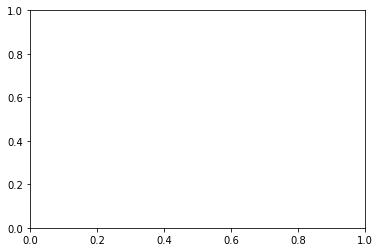

In [6]:
print(df.keys())
print(len(df))
val_arr = df.range_agent_measurement_noise.unique()
df_filtered = df[df["range_agent_measurement_noise"]==val_arr[4]]
len(df_filtered)
df['Netw_eigVals_vs_time']
sc_param1_arr = df['scalar_param1'].unique()
for sc_param in sc_param1_arr[2:3]:
    print(sc_param)
    # print(df[df['scalar_param1']==sc_param])
    df_tmp = df_filtered[df_filtered['scalar_param1']==sc_param].copy()
    for t in df_tmp['Timestep'].unique():
        print(t)
        # print(df_tmp.loc[df_tmp['Timestep']==t,'Netw_eigVals_vs_time'])
        df_tmp_at_time = df_tmp[df_tmp['Timestep']==0]['Netw_eigVals_vs_time']
        for row in df_tmp_at_time:
            norm_eigVal = row
            plt.scatter(t,norm_eigVal,alpha=0.01)

    

In [9]:
from multiprocessing import Pool
import networkx as nx

def parse_experiment_data_par(file_path):
    # print("File Path is: " + file_path)
    try:
    # if(True):
        # E_a, E_p, E_t, G, avgZArr, clustCoef, degreeDist, eigVal, eigVec, env_noise_std, mean_agent_measurement_noise, n_agents, range_agent_measurement_noise, scalar_param1, steps, weight_own_belief, z_gt, _, _ = extract_relevant_data_from_files(
            # file_path)

        E_a, E_p, E_t, adjc, G, avgZArr, clustCoef, degreeDist, eigVal, eigVec, env_noise_std, mean_agent_measurement_noise, n_agents, range_agent_measurement_noise, scalar_param1, steps, weight_own_belief, z_gt, zArr, pArr = extract_relevant_data_from_files(
            file_path)

    # print("eigVals list lenght: ", len(eigvals_time), flush=True)

        d = {"Trueness_Error": E_t, "Precision_Error": E_p, "Accuracy_Error": E_a, "Collective_Mean": avgZArr,
            "Number_of_Agents": [n_agents for _ in range(steps)], "True_Value": [z_gt for _ in range(steps)],
            "Timestep": [i for i in range(steps)],
            "mean_agent_measurement_noise": [mean_agent_measurement_noise for _ in range(steps)],
            "range_agent_measurement_noise": [range_agent_measurement_noise for _ in range(steps)],
            "std_environment_noise": [env_noise_std for _ in range(steps)],
            "scalar_param1": [scalar_param1 for _ in range(steps)],
            "weight_own_belief": [weight_own_belief for _ in range(steps)],
             # ToDo: Calculate Network properties for each time-step, so that we can see the evolution of these properties over time
            "Netw_num_of_Edges" : G.number_of_edges(),
            "Netw_std_degree" : np.std(degreeDist),
            "Netw_mean_degree" : np.mean(degreeDist),
            "Netw_std_eigVec" : np.std(eigVec),
            "Netw_mean_eigVec" : np.mean(eigVec),
            "Netw_max_eigVec" : np.max(eigVec),
            "Netw_std_CC" : np.std(clustCoef),
            "Netw_mean_CC" : np.mean(clustCoef),
            "Netw_max_CC" : np.max(clustCoef),
            "Netw_std_eigVal" : np.std(eigVal),
            "Netw_mean_eigVal" : np.mean(eigVal),
            "Netw_max_eigVal" : np.max(eigVal), #}##,#[-1],
            "Netw_2ndmax_eigVal" : eigVal[-2]}#,
            # "Netw_Adjc" : adjc_time,
            # "Netw_eigVals_vs_time" : eigvals_time}
            # "Netw_eigVals_vs_time" : [get_eigVals_of_adj_mat(nx.from_numpy_array(adjc[i].cpu().detach().numpy())) for i in range(steps)]}

        return pd.DataFrame.from_dict(d)
    except Exception as e:
    # else:
        print(e, flush=True)
        print("Something Went Wrong!",flush=True)


def parse_experiment_data_par_bayes(file_path):
    # print("File Path is: " + file_path)
    try:
    # if(True):
        # print("Dummy Check!", flush=True)

        # remove "data.pickle5" from file_path
        file_path = file_path.replace("data.pickle5", "")
        file_path = file_path.replace("config.yaml", "")

        pickleFileName = file_path+"/data.pickle5"
        yamlFileName = file_path+"/config.yaml"

        with open(pickleFileName, "rb") as f:
            resFile = pickle.load(f)

        with open(yamlFileName, 'r') as f:
            configData = dcargs.from_yaml(ExperimentParameters, f)


        n_agents = configData.network_params.n_agents
        steps = configData.steps + 1 
        z_gt = configData.true_value

        # not checked yet
        range_agent_measurement_noise = configData.network_params.max_agent_measurement_noise - configData.network_params.min_agent_measurement_noise
        mean_agent_measurement_noise = 0.5*(configData.network_params.max_agent_measurement_noise + configData.network_params.min_agent_measurement_noise)
        env_noise_std = configData.env_noise_std
        scalar_param1 = configData.network_params.scalar_param1
        weight_own_belief = configData.network_params.weight_own_belief

        colData = resFile['collective_data']
        adjc = colData['connectivity']
        agntData = colData['agent_data']

        # print("nAgents: " + str(n_agents) + ", steps: " + str(steps));
        # print("agnt data: ", len(agntData))

        zArr = np.zeros((n_agents,steps))
        pArr = zArr.copy()

        for i in range(n_agents):
            z = agntData[i].belief_mean
            std = agntData[i].belief_std
            zArr[i,:] = z
            pArr[i,:] = std
    
        avgZArr = np.mean(zArr, axis=0)
        E_t = (avgZArr-z_gt)**2
        E_p2 = (zArr - avgZArr)**2
        E_p = np.mean(E_p2, axis=0)
        E_a = E_t + E_p

        G = nx.from_numpy_array(adjc[0].cpu().detach().numpy())
        # print(G, flush=True)
        degreeDist = np.array(G.degree())[:, 1]
        clustCoef = np.array(list(nx.clustering(G).values()))
        eigVec = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

        ind_central = np.argmax(eigVec)
        ind_peripheral = np.argmin(eigVec)

        confidence_arr = []
        confident_central_node = []
        confident_peripheral_node = []
        confident_avg_nodes = []        
        E_T_central_node = []
        E_T_peripheral_node = []
        E_T_all_nodes = []    

        dist_to_center_all_nodes = []
        dist_to_center_central_node = []
        dist_to_center_peripheral_node = []

        z_arr_time = []

        for i in range(steps):
            confidence_all_tmp = pArr[:,i].T
            confidence_arr.append(confidence_all_tmp)
            confident_central_node.append(confidence_all_tmp[ind_central])
            confident_peripheral_node.append(confidence_all_tmp[ind_peripheral])
            confident_avg_nodes.append(np.mean(confidence_all_tmp))

            E_T_all_tmp = (zArr[:,i].T - z_gt)**2
            E_T_all_nodes.append(E_T_all_tmp)
            E_T_central_node.append(E_T_all_tmp[ind_central])
            E_T_peripheral_node.append(E_T_all_tmp[ind_peripheral])

            mean_zArr = np.mean(zArr[:,i])

            dist_to_center_all_nodes_tmp = (zArr[:,i].T - mean_zArr)**2;
            dist_to_center_central_node.append(dist_to_center_all_nodes_tmp[ind_central])
            dist_to_center_peripheral_node.append(dist_to_center_all_nodes_tmp[ind_peripheral])
            dist_to_center_all_nodes.append(dist_to_center_all_nodes_tmp)

            z_arr_time.append(zArr[:,i])



        # print("Dummy Check3 !", flush=True)

        GG = nx.adjacency_matrix(G).toarray()
        row_sums = GG.sum(axis=1)
        row_sums[row_sums==0] = 1
        row_sums[np.isinf(row_sums)] = 1
        G2 = GG / row_sums[:, np.newaxis]
        eigVal = np.linalg.eigvals(G2)
        eigVal[np.isinf(eigVal)] = np.iinfo(np.int16).max
        # eigVal[np.isinf(eigVal) + np.isnan(eigVal)] = -1.01
        # eigVal = np.sort(np.abs(eigVal))

        # print("Start Testing Adjc Over Time! for steps: ", steps, flush=True)
        eigvals_time = []
        adjc_time = []
        for t in range(steps):
            # print(t)
            G = nx.from_numpy_array(adjc[t].cpu().detach().numpy())
            GG = nx.adjacency_matrix(G).toarray()
            row_sums = GG.sum(axis=1)
            row_sums[row_sums==0] = 1
            row_sums[np.isinf(row_sums)] = 1
            G2 = GG / row_sums[:, np.newaxis]
            eigVal = np.linalg.eigvals(G2)
            # eigVal[np.isinf(eigVal) + np.isnan(eigVal)] = -1.01
            eigVal[np.isinf(eigVal)] = np.iinfo(np.int16).max
            # L = nx.normalized_laplacian_matrix(G)
            # eigVal = np.array(list(nx.eigenvector_centrality(G).values()))
            # print("eigVals lenght: ", eigVal.shape, flush=True)
            eigvals_time.append(eigVal)
            adjc_time.append(adjc[t].cpu().detach().numpy())

        # print("eigVals list lenght: ", len(eigvals_time), flush=True)

        d = {"Trueness_Error": E_t, "Precision_Error": E_p, "Accuracy_Error": E_a, "Collective_Mean": avgZArr,
             "confidence_arr" : confidence_arr,
             "z_arr" : z_arr_time,
             "E_T_all_nodes" : E_T_all_nodes,
             "dist_to_center_all_nodes" : dist_to_center_all_nodes,
            "Number_of_Agents": [n_agents for _ in range(steps)], "True_Value": [z_gt for _ in range(steps)],
            "Timestep": [i for i in range(steps)],
            "mean_agent_measurement_noise": [mean_agent_measurement_noise for _ in range(steps)],
            "range_agent_measurement_noise": [range_agent_measurement_noise for _ in range(steps)],
            "std_environment_noise": [env_noise_std for _ in range(steps)],
            "scalar_param1": [scalar_param1 for _ in range(steps)],
            "weight_own_belief": [weight_own_belief for _ in range(steps)],
             # ToDo: Calculate Network properties for each time-step, so that we can see the evolution of these properties over time
            "Netw_num_of_Edges" : G.number_of_edges(),
            "Netw_std_degree" : np.std(degreeDist),
            "Netw_mean_degree" : np.mean(degreeDist),
            "Netw_std_eigVec" : np.std(eigVec),
            "Netw_mean_eigVec" : np.mean(eigVec),
            "Netw_max_eigVec" : np.max(eigVec),
            "Netw_std_CC" : np.std(clustCoef),
            "Netw_mean_CC" : np.mean(clustCoef),
            "Netw_max_CC" : np.max(clustCoef),
            "Netw_std_eigVal" : np.std(eigVal),
            "Netw_mean_eigVal" : np.mean(eigVal),
            "Netw_max_eigVal" : np.max(eigVal),#[-1],
            # "Netw_2ndmax_eigVal" : eigVal[-2],
            # "Netw_Adjc" : adjc_time,
            "Netw_eigVals_vs_time" : eigvals_time,
            "adjc_time" : adjc_time}
            # "Netw_eigVals_vs_time" : [get_eigVals_of_adj_mat(nx.from_numpy_array(adjc[i].cpu().detach().numpy())) for i in range(steps)]}

        return pd.DataFrame.from_dict(d)
    except Exception as e:
    # else:
        print(e, flush=True)
        print("Something Went Wrong!",flush=True)

def extract_relevant_data_from_files(file_path):
    pickleFileName = file_path + "/data.pickle5"
    yamlFileName = file_path + "/config.yaml"
    with open(pickleFileName, "rb") as f:
        resFile = pickle.load(f)
    with open(yamlFileName, 'r') as f:
        configData = dcargs.from_yaml(ExperimentParameters, f)
    n_agents = configData.network_params.n_agents

    steps = configData.steps + 1
    z_gt = configData.true_value
    # not checked yet
    range_agent_measurement_noise = configData.network_params.max_agent_measurement_noise - configData.network_params.min_agent_measurement_noise
    mean_agent_measurement_noise = 0.5 * (
                configData.network_params.max_agent_measurement_noise + configData.network_params.min_agent_measurement_noise)
    env_noise_std = configData.env_noise_std
    scalar_param1 = configData.network_params.scalar_param1
    weight_own_belief = configData.network_params.weight_own_belief
    colData = resFile['collective_data']
    adjc = colData['connectivity']
    agntData = colData['agent_data']
    # print("nAgents: " + str(n_agents) + ", steps: " + str(steps));
    # print("agnt data: ", len(agntData))
    zArr = np.zeros((n_agents, steps))
    pArr = zArr.copy()
    for i in range(n_agents):
        z = agntData[i].belief_mean
        std = agntData[i].belief_std
        zArr[i, :] = z
        pArr[i, :] = std
    avgZArr = np.mean(zArr, axis=0)
    E_t = (avgZArr - z_gt) ** 2
    E_p2 = (zArr - avgZArr) ** 2
    E_p = np.mean(E_p2, axis=0)
    E_a = E_t + E_p
    G = nx.from_numpy_array(adjc[0].cpu().detach().numpy())
    degreeDist = np.array(G.degree())[:, 1]
    clustCoef = np.array(list(nx.clustering(G).values()))
    eigVec = np.array(list(nx.eigenvector_centrality_numpy(G).values()))
    GG = nx.adjacency_matrix(G).toarray()
    row_sums = GG.sum(axis=1)
    row_sums[row_sums == 0] = 1
    row_sums[np.isinf(row_sums)] = 1
    G2 = GG / row_sums[:, np.newaxis]
    eigVal = np.linalg.eigvals(G2)
    eigVal[np.isinf(eigVal)] = np.iinfo(np.int16).max
    # eigVal[np.isinf(eigVal) + np.isnan(eigVal)] = -1.01
    # eigVal = np.sort(np.abs(eigVal))
    # # print("Start Testing Adjc Over Time! for steps: ", steps)
    # eigvals_time = []
    # # adjc_time = []
    # for t in range(steps):
    #     # print(t)
    #     G = nx.from_numpy_array(adjc[t].cpu().detach().numpy())
    #     GG = nx.adjacency_matrix(G).toarray()
    #     row_sums = GG.sum(axis=1)
    #     row_sums[row_sums==0] = 1
    #     G2 = GG / row_sums[:, np.newaxis]
    #     eigVal = np.linalg.eigvals(G2)
    #     # eigVal[np.isinf(eigVal) + np.isnan(eigVal)] = -1.01
    #     # L = nx.normalized_laplacian_matrix(G)
    #     # eigVal = np.array(list(nx.eigenvector_centrality(G).values()))
    #     # print("eigVals lenght: ", eigVal.shape, flush=True)
    #     eigvals_time.append(eigVal)
    #     # adjc_time.append(adjc[t].cpu().detach().numpy())
    return E_a, E_p, E_t, adjc, G, avgZArr, clustCoef, degreeDist, eigVal, eigVec, env_noise_std, mean_agent_measurement_noise, n_agents, range_agent_measurement_noise, scalar_param1, steps, weight_own_belief, z_gt, zArr, pArr



# def process_file(base_file_path):
def parse_experiments(base_file_path):
    pathes = glob.glob(os.path.join(base_file_path, "*"))
    pool = Pool(10)
    dataframes = pool.imap(parse_experiment_data_par, tqdm(pathes))#[479400:-1]))#[0:460000]))
    #   dataframes.append(parse_experiment_data_par(p))
    #   dataframes = [parse_experiment_data(p) for p in tqdm(pathes)]
    return pd.concat(dataframes, ignore_index=True)


# experiment_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-10-29-15-36-50_test_grid_search_Bayes/" 
# experiment_path = "/home/mohsen/Project/colab/collective-decison-making-with-direl/results/2022-11-08-17-57-46_test_grid_search_Naive/"

# df = parse_experiments(experiment_path)

In [10]:
def draw_network_color_nodes_on_degree(G, ax=None):
    # pos = nx.spring_layout(G, seed=100)  # Seed layout for reproducibility
    pos = nx.spring_layout(G, k=0.01, iterations=20)

    # change the layout based on the node centrality + spring layout so that they don't stick together
    # pos = nx.spectral_layout(G)
    # pos = nx.spring_layout(G, k=0.01, iterations=2, pos=pos)
    # 
    # pos = nx.spiral_layout(G)

    # pos = nx.shell_layout(G)
    # pos = nx.random_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.circular_layout(G)
    # pos = nx.fruchterman_reingold_layout(G)
    # pos = nx.planar_layout(G)
    # pos = nx.rescale_layout(G)
    # pos = nx.bipartite_layout(G)
    # pos = nx.multipartite_layout(G)
    
    node_color = []
    degree_dist = np.array(G.degree())[:,1]
    for i_node in G.nodes():
        node_color.append((degree_dist[i_node]/degree_dist.max(),0,0))
    options = {
        "node_color": node_color, #"#A0CBE2",
        "edge_color": "#6BCBFF",
        "width": 1,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
        "node_size": 1000/G.number_of_nodes(),
    }
    if(ax is None):
        nx.draw(G, pos, **options)
    else:
        nx.draw(G, pos, ax=ax, **options)

In [76]:
from multiprocessing import Pool
import networkx as nx


# experiment_name = "2022-11-24-15-26-41_test_grid_search_Naive"
# experiment_name = "N100_2023-04-18-11-16-30_test_grid_search_BayesCI_centralized_random/results"
# experiment_name = "N100_2023-08-18-17-24-37_network_search_Bayes_centralized_random_fixed_mdeg/results"

experiment_name = ("N100_2023-08-18-17-24-37_network_search_Bayes_centralized_random_fixed_mdeg/results/"
"envstd_3_mnint_0_mncenter_0_np1_3_ow_0_a_n_0_run_60")


experiment_name = ("N100_2023-09-15-18-09-46_certainty_search_Bayes_centralized_random_fixed_mdeg/results/"
"envstd_3_mnint_0_mncenter_0_np1_3_ow_0_a_n_0_run_60")



# experiment_name = ("N100_2023-08-18-17-16-12_network_search_Naive_centralized_random_fixed_mdeg/results/"
#                    "envstd_9_mnint_0_mncenter_0_np1_0_ow_7_a_n_0_run_78")




experiment_folder_path = default_path + "/" + experiment_name 

base_file_path = experiment_folder_path

pathes = glob.glob(os.path.join(base_file_path, "*"))
# print(pathes)
print("-------------------")
# n_file_to_read = 1205; # BayesCI
n_file_to_read = 1
print(pathes[n_file_to_read])
file_path = pathes[n_file_to_read]

df_tst = None
if("Bayes" in experiment_name):
    df_tst = parse_experiment_data_par_bayes(file_path)
else:
    df_tst = parse_experiment_data_par(file_path)   
# df_tst = parse_experiment_data_par_bayes(file_path) 
# 

from importlib import reload

reload(postpro)
df_tmp = postpro.post_pro_network_centrality_certainty(file_path)

# print(df_tst.weight_own_belief)

-------------------


IndexError: list index out of range

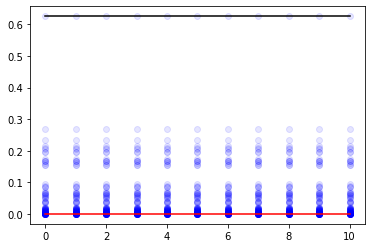

In [74]:
%matplotlib inline
# print(df_tmp.keys())
# print(df_tmp["eig_val_central_node"])

for t in df_tmp['Timestep'].unique():
    plt.scatter(t*np.ones(100),df_tmp["Netw_eigVals_vs_time"][t],alpha=0.1,c="b")
    # print(np.sort(df_tmp["Netw_eigVals_vs_time"][t])==np.sort(df_tmp["Netw_eigVals_vs_time"][t+1]))
    # plt.scatter(t,df_tmp["Netw_eigVals_vs_time"][t][df_tmp["confident_central_node"]],alpha=0.1,c="b")

plt.plot(df_tmp["eig_val_peripheral_node"],c="r");
plt.plot(df_tmp["eig_val_central_node"],c="k");

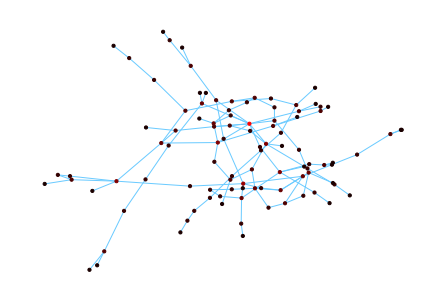

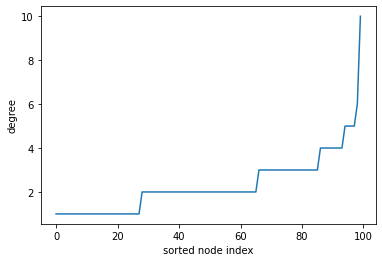

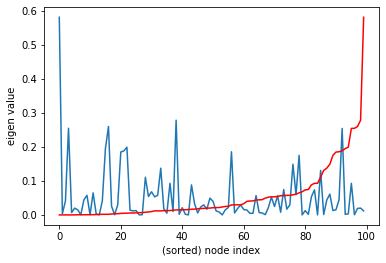

index central node:  0
index peripheral node:  26


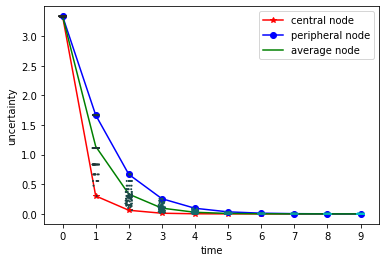

In [49]:
import seaborn as sns

df_tst.adjc_time[1].shape

G = nx.from_numpy_array(df_tst.adjc_time[1])
GG = nx.adjacency_matrix(G).toarray() 

# # For Naive we should remove the self links and make the G based on that
GG = GG - np.diag(np.diag(GG))
G = nx.from_numpy_array(GG)


# print(G, flush=True)
degreeDist = np.array(G.degree())[:, 1]
clustCoef = np.array(list(nx.clustering(G).values()))
eigVec = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

row_sums = GG.sum(axis=1)
row_sums[row_sums==0] = 1
row_sums[np.isinf(row_sums)] = 1
G2 = GG / row_sums[:, np.newaxis]
eigVal = np.linalg.eigvals(G2)
eigVal[np.isinf(eigVal)] = np.iinfo(np.int16).max

# nx.draw(G, with_labels=False)
draw_network_color_nodes_on_degree(G)
plt.show()

plt.plot(np.sort(degreeDist))
plt.xlabel('sorted node index')
plt.ylabel('degree')
fig = plt.gcf()
fig.set_facecolor('white')
plt.show()

plt.plot(eigVec)
plt.plot(np.sort(eigVec),'r')
plt.xlabel('(sorted) node index')
plt.ylabel('eigen value')
fig = plt.gcf()
fig.set_facecolor('white')
plt.show()

# find the node with largest eigVec: central node
ind_central = np.argmax(eigVec)
print("index central node: ", ind_central)

# find the node with smallest eigVec: peripheral node
ind_peripheral = np.argmin(eigVec)
print("index peripheral node: ", ind_peripheral)

confident_central_node = []
confident_peripheral_node = []
confident_all_nodes = []
confident_avg_nodes = []
for time_ind in range(1,11):
    confident_central_node.append(df_tst.confidence_arr[time_ind][ind_central])
    confident_peripheral_node.append(df_tst.confidence_arr[time_ind][ind_peripheral])
    confident_all_nodes.append(df_tst.confidence_arr[time_ind][:])
    confident_avg_nodes.append(np.mean(df_tst.confidence_arr[time_ind][:]))

# plt.plot(np.arange(0,10), confident_all_nodes,'c.', markersize=1);
sns.stripplot(data=confident_all_nodes, jitter=0.1, size=2, palette='dark:c')
plt.plot(confident_central_node, 'r-*', label='central node')
plt.plot(confident_peripheral_node, 'b-o', label='peripheral node')
plt.plot(np.arange(0,10), confident_avg_nodes,'g-', label='average node')
plt.xlabel('time')
plt.ylabel('uncertainty')
# plt.yscale("log")
# set face color to white
ax = plt.gca()
ax.set_facecolor('white')
# set face color of the fig white
fig = plt.gcf()
fig.set_facecolor('white')
# plt.ylim([1e-14, 1e-3])
# print(plt.ylim())
plt.legend()
plt.show()





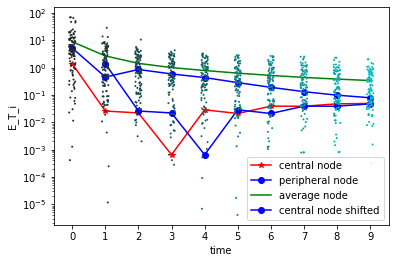

In [50]:
E_T_central_node = []
E_T_peripheral_node = []
E_T_all_nodes = []
E_T_avg_nodes = []
for time_ind in range(1,11):
    E_T_central_node.append(df_tst.E_T_all_nodes[time_ind][ind_central])
    E_T_peripheral_node.append(df_tst.E_T_all_nodes[time_ind][ind_peripheral])
    E_T_all_nodes.append(df_tst.E_T_all_nodes[time_ind][:])
    E_T_avg_nodes.append(np.mean(df_tst.E_T_all_nodes[time_ind][:]))


sns.stripplot(data=E_T_all_nodes, jitter=0.1, size=2, palette='dark:c')
plt.plot(E_T_central_node, 'r-*', label='central node')
plt.plot(E_T_peripheral_node, 'b-o', label='peripheral node')
plt.plot(np.arange(0,10), E_T_avg_nodes,'g-', label='average node')

E_T_central_node = np.roll(E_T_central_node,1)
E_T_central_node[0] = np.nan
plt.plot(E_T_central_node, 'b-o', label='central node shifted')

plt.xlabel('time')
plt.ylabel('E_T_i')
plt.yscale("log")
# set face color to white
ax = plt.gca()
ax.set_facecolor('white')
# set face color of the fig white
fig = plt.gcf()
fig.set_facecolor('white')
# print(plt.ylim())
plt.legend()
plt.show()

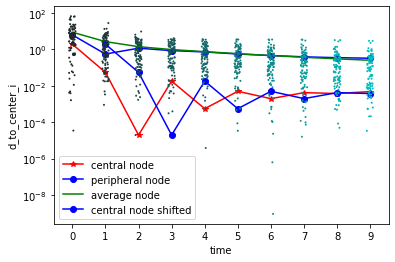

In [51]:
d_to_center_central_node = []
d_to_center_peripheral_node = []
d_to_center_all_nodes = []
d_to_center_avg_nodes = []
for time_ind in range(1,11):
    d_to_center_central_node.append(df_tst.dist_to_center_all_nodes[time_ind][ind_central])
    d_to_center_peripheral_node.append(df_tst.dist_to_center_all_nodes[time_ind][ind_peripheral])
    d_to_center_all_nodes.append(df_tst.dist_to_center_all_nodes[time_ind][:])
    d_to_center_avg_nodes.append(np.mean(df_tst.dist_to_center_all_nodes[time_ind][:]))


sns.stripplot(data=d_to_center_all_nodes, jitter=0.1, size=2, palette='dark:c')
plt.plot(d_to_center_central_node, 'r-*', label='central node')
plt.plot(d_to_center_peripheral_node, 'b-o', label='peripheral node')
plt.plot(d_to_center_avg_nodes,'g-', label='average node')

d_to_center_central_node = np.roll(d_to_center_central_node,1)
d_to_center_central_node[0] = np.nan
plt.plot(d_to_center_central_node, 'b-o', label='central node shifted')


plt.xlabel('time')
plt.ylabel('d_to_center_i')
plt.yscale("log")
# set face color to white
ax = plt.gca()
ax.set_facecolor('white')
# set face color of the fig white
fig = plt.gcf()
fig.set_facecolor('white')
plt.legend()
plt.show()

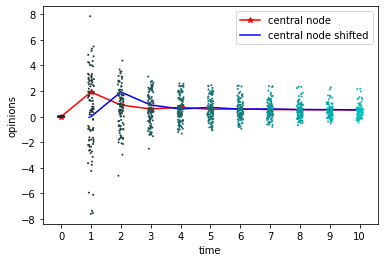

In [52]:
z_central_node = []
z_all = []
for time_ind in range(0,11):
    z_all.append(df_tst.z_arr[time_ind][:])
    z_central_node.append(df_tst.z_arr[time_ind][ind_central])
sns.stripplot(data=z_all, jitter=0.1, size=2, palette='dark:c')
plt.plot(z_central_node, 'r-*', label='central node')
# plot shifted z_central by 1 index
z_central_shifted = np.roll(z_central_node,1)
z_central_shifted[0] = np.nan
plt.plot(z_central_shifted, 'b-', label='central node shifted')

plt.xlabel('time')
plt.ylabel('opinions')
# set face color to white
ax = plt.gca()
ax.set_facecolor('white')
# set face color of the fig white
fig = plt.gcf()
fig.set_facecolor('white')
plt.legend()
plt.show()

average displacement:  7.236207398176194 , for central node:  5.303435802459717


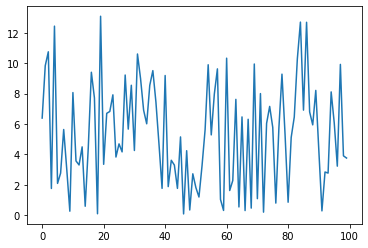

In [144]:
diff_z_tf = np.abs(df_tst.z_arr[10][:] - df_tst.z_arr[0][:])
diff_z_tf_central_node = diff_z_tf[ind_central]

diff_z_all = np.diff(z_all, axis=0)

abs_diff_z_all = np.abs(diff_z_all)
sum_over_t_abs_diff_z = np.sum(abs_diff_z_all, axis=0)
avg_sum_over_t_abs_diff_z = np.mean(sum_over_t_abs_diff_z)
print("average displacement: ", avg_sum_over_t_abs_diff_z, ", for central node: ", sum_over_t_abs_diff_z[ind_central])



plt.plot(diff_z_tf)

average dot product:  0.46
-27.563913097239176


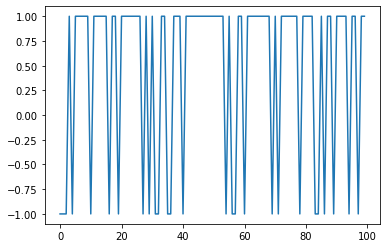

In [163]:
moved_vector_all = z_all[9] - z_all[0]
center_moved_vec = np.mean(z_all[9]) - np.mean(z_all[0])
# central_moved_vec = moved_vector_all[ind_central]

dot_prod_all = np.dot(moved_vector_all, center_moved_vec)
central_dot_prod = dot_prod_all[ind_central]

sign_dot_prod_all = np.sign(dot_prod_all)
print("average dot product: ", np.mean(sign_dot_prod_all))

# plt.plot(dot_prod_all)
plt.plot(np.sign(dot_prod_all))
print(central_dot_prod)
# plt.plot(np.sign(moved_vector_all))

In [145]:
print(z_central_shifted)
print(z_central_node)

[         nan -11.68758106 -10.37201023  -9.34878826  -8.55294895
  -7.9339633   -7.45252991  -7.07808161  -6.78684425  -6.5603261 ]
[-11.687581062316895, -10.372010231018066, -9.348788261413574, -8.552948951721191, -7.933963298797607, -7.4525299072265625, -7.0780816078186035, -6.786844253540039, -6.560326099395752, -6.384145259857178]


/tmp/ipykernel_452060/4045757713.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


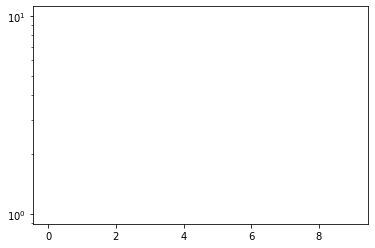

In [146]:
# plot the distance between the central node and the peripheral node
diff_certainty_min_max = np.array(confident_peripheral_node)-np.array(confident_central_node)
plt.plot(diff_certainty_min_max, 'r-*', label='diff certainty')
plt.yscale("log")

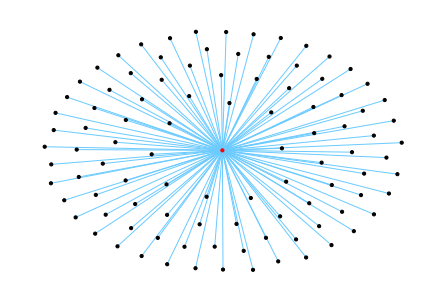

In [147]:
pos = nx.spring_layout(G, k=0.1, iterations=5000)
# pos = nx.spectral_layout(G)
# pos = nx.spring_layout(G, k=0.01, iterations=2, pos=pos)
# pos = nx.spiral_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.random_layout(G)
# pos = nx.kamada_kawai_layout(G)
# pos = nx.circular_layout(G)
# pos = nx.fruchterman_reingold_layout(G)
# pos = nx.planar_layout(G)
# pos = nx.rescale_layout(G)
# pos = nx.bipartite_layout(G)
# pos = nx.multipartite_layout(G)
    
node_color = []
degree_dist = np.array(G.degree())[:,1]
for i_node in G.nodes():
    node_color.append((degree_dist[i_node]/degree_dist.max(),0,0))
options = {
    "node_color": node_color, #"#A0CBE2",
    "edge_color": "#6BCBFF",
    "width": 1,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
    "node_size": 1000/G.number_of_nodes(),
}

nx.draw(G, pos, **options)